In [1]:
!pip install torchinfo

In [2]:
import numpy as np
import pandas as pd
import cv2

import torch
from torch.utils.data import DataLoader, Subset, Dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc

import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models.detection import faster_rcnn

from torchinfo import summary
import albumentations as A

from tqdm import tqdm

from collections import defaultdict
import pathlib
import copy
import os
import sys
import random

In [3]:
rc('figure', **{'dpi': 150})

### OpenImages v4

https://www.tensorflow.org/datasets/catalog/open_images_v4

In [4]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422 (from 1)
Receiving objects: 100% (422/422), 34.08 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [5]:
!pip install -U awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.42.36
    Uninstalling botocore-1.42.36:
      Successfully uninstalled botocore-1.42.36
  Attempting uninstall: awscli
    Found existing installation: awscli 1.44.26
    Uninstalling awscli-1.44.26:
      Successfully uninstalled awscli-1.44.26


In [6]:
# download two classes from OpenImages, 500 images each
! cd OIDv4_ToolKit && python3 main.py downloader --classes Cat Dog --type_csv train --limit 500 -y

/content/OIDv4_ToolKit/modules/utils.py:127: SyntaxWarning: invalid escape sequence '\ '
  /  .-.  \ | |    | | `. \ _   __ | |__| |_
/content/OIDv4_ToolKit/modules/utils.py:136: SyntaxWarning: invalid escape sequence '\ '
  (____ \                  | |               | |
/content/OIDv4_ToolKit/modules/utils.py:149: SyntaxWarning: invalid escape sequence '\ '
  \ \/ /| |/___) | | |/ _  | | (___  ) _  )/ ___)
/content/OIDv4_ToolKit/modules/utils.py:159: SyntaxWarning: invalid escape sequence '\ '
  |  __ \                    | |               | |           |_   _| |    | |
/content/OIDv4_ToolKit/modules/show.py:55: SyntaxWarning: invalid escape sequence '\s'
  match_class_name = re.compile('^[a-zA-Z]+(\s+[a-zA-Z]+)*').match(line)

		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'

In [7]:
! cd OIDv4_ToolKit && python3 main.py downloader --classes Castle --type_csv train --limit 1000 --n_threads 10 -y


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Castle.

Castle
    [INFO] | Downloading train images.
    [INFO] | [INFO] Found 3738 online images for train.
    [INFO] | Limiting to 1000 images.
    [INFO] | Download of 1000 images in train.


In [9]:
! cd ./OIDv4_ToolKit/OID/Dataset/train/Castle/ && ls -1 | wc -l
! cd ./OIDv4_ToolKit/OID/Dataset/test/Castle/ && ls -1 | wc -l

1001
72


In [10]:
annotations_csv = pd.read_csv("./OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv")

In [11]:
cat_id = "/m/01yrx"
dog_id = "/m/0bt9lr"

In [12]:
cat_rows = annotations_csv[annotations_csv["LabelName"] == cat_id]
dog_rows = annotations_csv[annotations_csv["LabelName"] == dog_id]

In [13]:
# IsOccluded = partially hidden
# IsTruncated = object cut off by image border
# IsGroupOf = crowd
# IsDepiction = not real, drawing statue photo ..
# IsInside = object is inside another object
cat_rows.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
1709   0000de486dc6c49f  xclick  /m/01yrx           1  0.019608  0.998366   
7930   00056e547b7c00d6  xclick  /m/01yrx           1  0.003125  0.999375   
9109   00067fe83e3e21c8  xclick  /m/01yrx           1  0.156250  0.691875   
11627  0008ab3d8674f6ca  xclick  /m/01yrx           1  0.099167  0.713333   
13871  000aa552a9d80891  xclick  /m/01yrx           1  0.000000  0.772500   

           YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
1709   0.024510  0.977124           1            1          0            0   
7930   0.007500  0.999167           0            1          0            0   
9109   0.000000  0.983067           1            0          0            0   
11627  0.396875  0.706250           0            0          0            0   
13871  0.000000  0.998889           0            1          0            0   

       IsInside  
1709          0  
7930          0  
9109          0  
11627         0  
13871         0

In [14]:
dog_rows.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
1151  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1242  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
3730  000256419f7c57d8  xclick  /m/0bt9lr           1  0.190625  0.301250   
3731  000256419f7c57d8  xclick  /m/0bt9lr           1  0.450000  0.562500   
3732  000256419f7c57d8  xclick  /m/0bt9lr           1  0.558750  0.615625   

          YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
1151  0.268333  0.998333           1            1          0            0   
1242  0.000000  0.999062           1            1          0            0   
3730  0.530000  0.650000           1            0          0            0   
3731  0.485833  0.598333           1            0          0            0   
3732  0.515000  0.592500           1            0          0            0   

      IsInside  
1151         0  
1242         0  
3730         0  
3731         0  
3732         0

In [15]:
! cd ./OIDv4_ToolKit/OID/Dataset/train/Cat && ls -1 | wc -l
! cd ./OIDv4_ToolKit/OID/Dataset/train/Dog && ls -1 | wc -l

501
501


In [16]:
!wget -nc https://coudroncharolais.com/wp-content/uploads/2019/02/CC-Carly-Rae-2361-PLD.jpg

File ‘CC-Carly-Rae-2361-PLD.jpg’ already there; not retrieving.



(300, 380, 3)


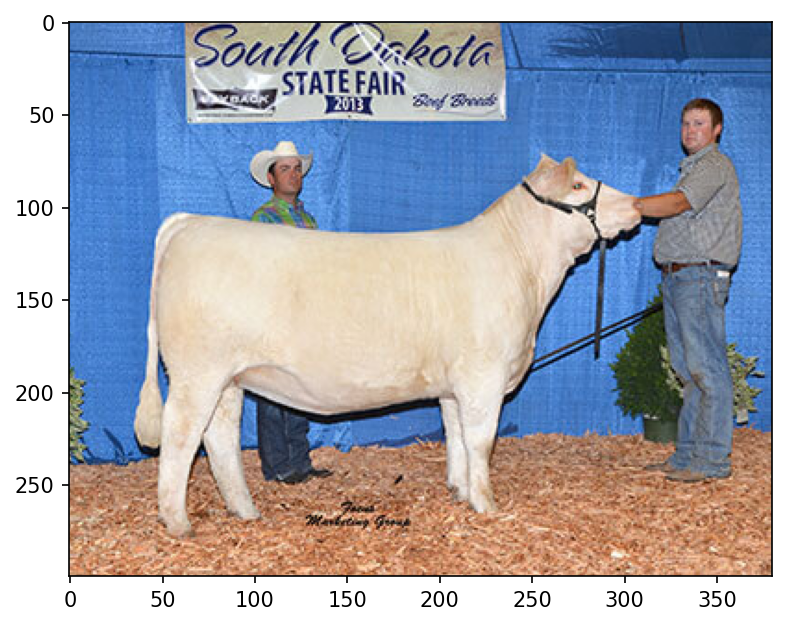

In [17]:
image_path = "CC-Carly-Rae-2361-PLD.jpg"

img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

print(img.shape)    # H, W, C numpy format
plt.imshow(img)

In [18]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [19]:
batch = transforms(img).unsqueeze(0)
batch.shape

torch.Size([1, 3, 300, 380])

### Faster R-CNN

FasterRCNN_MobileNet_V3_Large_FPN_Weights

In [20]:
detector = fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT, box_nms_thresh=0.5)

In [21]:
classes = FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1.meta['categories']
len(classes)

91

In [22]:
classes

['__background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'N/A',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'N/A',
 'backpack',
 'umbrella',
 'N/A',
 'N/A',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'N/A',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'N/A',
 'dining table',
 'N/A',
 'N/A',
 'toilet',
 'N/A',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'N/A',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

In [23]:
# inference mode

#   (transform): GeneralizedRCNNTransform(
#       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#       Resize(min_size=(800,), max_size=1333, mode='bilinear')
#   )

detector.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

each prediction returns

- boxes
- labels
- confidence_scores

In [24]:
results = detector(batch)
result = results[0]
result

{'boxes': tensor([[291.7176,  41.2386, 365.6906, 248.4371],
         [ 37.7425,  62.7932, 318.3884, 276.8350],
         [ 95.2225,  65.3128, 135.5113, 113.6559],
         [ 91.7455,  61.0340, 139.8679, 253.3572],
         [ 44.2407,  65.9434, 302.2089, 274.7910],
         [ 38.6615,  67.7288, 318.2109, 274.8061]], grad_fn=<StackBackward0>),
 'labels': tensor([ 1, 21,  1,  1, 20, 19]),
 'scores': tensor([0.9959, 0.9771, 0.9262, 0.5619, 0.4821, 0.0867],
        grad_fn=<IndexBackward0>)}

In [25]:
[classes[i] for i in list(result["labels"].numpy())]

['person', 'cow', 'person', 'person', 'sheep', 'horse']

In [26]:
def color(label):
  if label == 1:
    return (0,0,255)
  if label == 2:
    return (0,255,0)
  return (255, 0, 0)

In [27]:
def draw_boxes(
    img,
    labels,
    boxes,
    scores=None,
    classes=None,
    score_thresh=0.5,
    thickness=2,
    font_scale=0.5,
    color=color
):
    """
    Draw boxes + optional labels/scores on an RGB image.

    - `color(label)` should return BGR tuples for OpenCV drawing.
    """
    out = img.copy()

    # convert tensors -> numpy
    def to_np(x):
        if x is None:
            return None
        if hasattr(x, "detach"):
            return x.detach().cpu().numpy()
        return np.asarray(x)

    labels = to_np(labels)
    boxes = to_np(boxes)
    scores = to_np(scores)

    h, w = out.shape[:2]

    for idx, (lab, box) in enumerate(zip(labels, boxes)):
        sc = float(scores[idx]) if scores is not None else None
        if sc is not None and sc < score_thresh:
            continue

        x1, y1, x2, y2 = map(float, box)
        x1 = int(np.clip(round(x1), 0, w - 1))
        y1 = int(np.clip(round(y1), 0, h - 1))
        x2 = int(np.clip(round(x2), 0, w - 1))
        y2 = int(np.clip(round(y2), 0, h - 1))
        if x2 <= x1 or y2 <= y1:
            continue

        lab_i = int(lab)
        col = color(lab_i)  # BGR

        cv2.rectangle(out, (x1, y1), (x2, y2), col, thickness)

        # build label text
        name = classes[lab_i] if (classes is not None and lab_i < len(classes)) else str(lab_i)
        text = f"{name}"
        if sc is not None:
            text += f" {sc:.2f}"

        # simple filled label background
        (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        y_text_top = max(y1, th + baseline + 2)
        cv2.rectangle(out, (x1, y_text_top - th - baseline - 2), (x1 + tw + 4, y_text_top), col, -1)
        cv2.putText(
            out, text, (x1 + 2, y_text_top - baseline - 1),
            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), 1, cv2.LINE_AA
        )

    return out

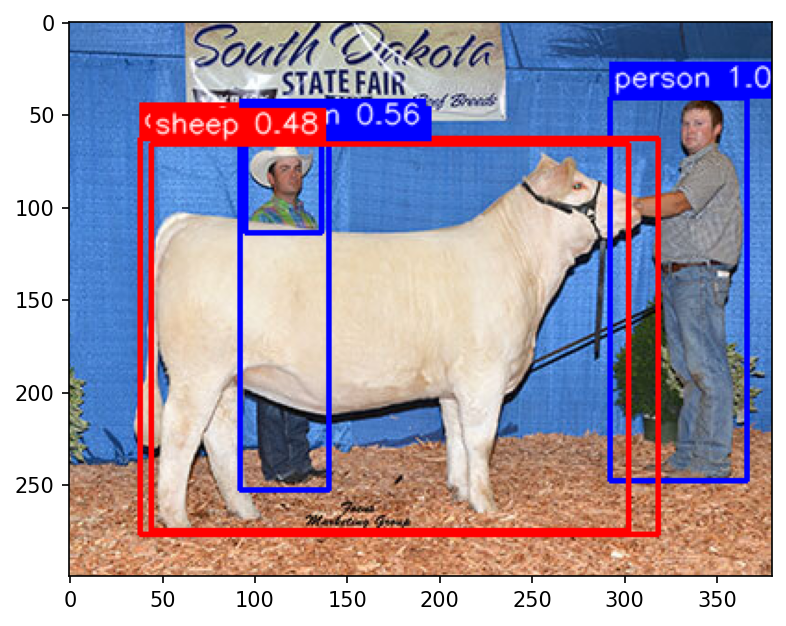

In [28]:
# note how non-maximum suppression is necessary even for two-stage detection

# RPN -> region proposals (candidate boxes) NMS
# RoI -> exact boxes in regression head
# still got overlapped boxes
plt.imshow(draw_boxes(img, result["labels"], result["boxes"], scores=result.get("scores"),
    classes=classes,
    score_thresh=0.3))

In [29]:
## wrapper class for the OpenImages dataset; probably best not to change anything :)
class OpenImagesDataset:
    def __init__(self, root,
                 transform=None,
                 dataset_type="train", classes_filter=None,
                 check_existance=True):
        self.root = pathlib.Path(root)
        self.transform = transform
        self.dataset_type = dataset_type.lower()
        self.check_existance = check_existance
        self.data, self.class_names, self.class_dict = self._read_data(classes_filter)
        self.min_image_num = -1
        print('map ids')
        self.ids = [info['image_id'] for info in self.data]
        self.class_stat = None

    def _getitem(self, index):
        image_info = self.data[index]
        image = self._read_image(image_info['class'], image_info['image_id'])
        # duplicate boxes to prevent corruption of dataset
        boxes = copy.copy(image_info['boxes'])
        boxes[:, 0] *= image.shape[1]
        boxes[:, 1] *= image.shape[0]
        boxes[:, 2] *= image.shape[1]
        boxes[:, 3] *= image.shape[0]
        # duplicate labels to prevent corruption of dataset
        labels = copy.copy(image_info['labels'])
        if self.transform:
            sample = self.transform(image = image,
                                    bboxes = boxes,
                                    labels = labels)

            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
        return image_info['image_id'], image, boxes, labels

    def __getitem__(self, index):
        image_id, image, boxes, labels = self._getitem(index)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image = image / 255
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = torch.tensor(labels)
        target["area"] = torch.tensor(area)
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor(index)
        return image, target

    def _read_data(self, classes_filter=None):
        print("load annotations")
        annotation_file = f"{self.root}/csv_folder/{self.dataset_type}-annotations-bbox.csv"
        annotations = pd.read_csv(annotation_file)

        print("load classes")
        classes_file = f"{self.root}/csv_folder/class-descriptions-boxable.csv"
        classes = pd.read_csv(classes_file, header=None, names=['LabelName', 'ClassName'])
        class_data = {}
        filtered_classes = classes[classes.LabelName.isin(annotations.LabelName.unique())]
        for index, row in filtered_classes.iterrows():
          if classes_filter is None or row['ClassName'] in classes_filter:
            class_data[row['LabelName']] = row['ClassName']

        print("assign class")
        annotations['ClassName'] = annotations.LabelName.map(lambda x: class_data[x] if x in class_data else 'NONE' )

        print("remove unused classes")
        annotations = annotations.drop(annotations[annotations.ClassName == 'NONE'].index)

        class_names = ['BACKGROUND'] + sorted(list(annotations['ClassName'].unique()))
        class_dict = {class_name: i for i, class_name in enumerate(class_names)}
        data = []

        print("aggregate image info")
        for image_id, group in annotations.groupby("ImageID"):
            clazz = [name for name in group["ClassName"]][0]
            fpath = self.root / "Dataset" / self.dataset_type / clazz / f"{image_id}.jpg"
            if self.check_existance and not os.path.exists(fpath):
                continue
            boxes = group.loc[:, ["XMin", "YMin", "XMax", "YMax"]].values.astype(np.float32)
            # make labels 64 bits to satisfy the cross_entropy function
            labels = np.array([class_dict[name] for name in group["ClassName"]], dtype='int64')
            data.append({
                'image_id': image_id,
                'boxes': boxes,
                'class': clazz,
                'labels': labels,
            })
        return data, class_names, class_dict

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.class_stat is None:
            self.class_stat = {name: 0 for name in self.class_names[1:]}
            for example in self.data:
                for class_index in example['labels']:
                    class_name = self.class_names[class_index]
                    self.class_stat[class_name] += 1
        content = ["Dataset Summary:"
                   f"Number of Images: {len(self.data)}",
                   f"Minimum Number of Images for a Class: {self.min_image_num}",
                   "Label Distribution:"]
        for class_name, num in self.class_stat.items():
            content.append(f"\t{class_name}: {num}")
        return "\n".join(content)

    def _read_image(self, clazz, image_id):
        image_file = self.root / "Dataset" / self.dataset_type / clazz / f"{image_id}.jpg"
        image = cv2.imread(str(image_file))
        if image is None:
          print("INVALID IMAGE", image_file)
        if image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image


In [30]:
dataset = OpenImagesDataset("OIDv4_ToolKit/OID", classes_filter=["Cat", "Dog"])

load annotations
load classes
assign class
remove unused classes
aggregate image info
map ids


In [31]:
new_classes = dataset.class_names
dataset

Dataset Summary:Number of Images: 997
Minimum Number of Images for a Class: -1
Label Distribution:
	Cat: 592
	Dog: 720

In [32]:
dataset.class_dict

{'BACKGROUND': 0, 'Cat': 1, 'Dog': 2}

Image dtype = float64
{'boxes': tensor([[408.3200, 276.4800, 608.0000, 696.3203]]), 'labels': tensor([2]), 'area': tensor([83833.6953]), 'iscrowd': tensor([0]), 'image_id': tensor(5)}


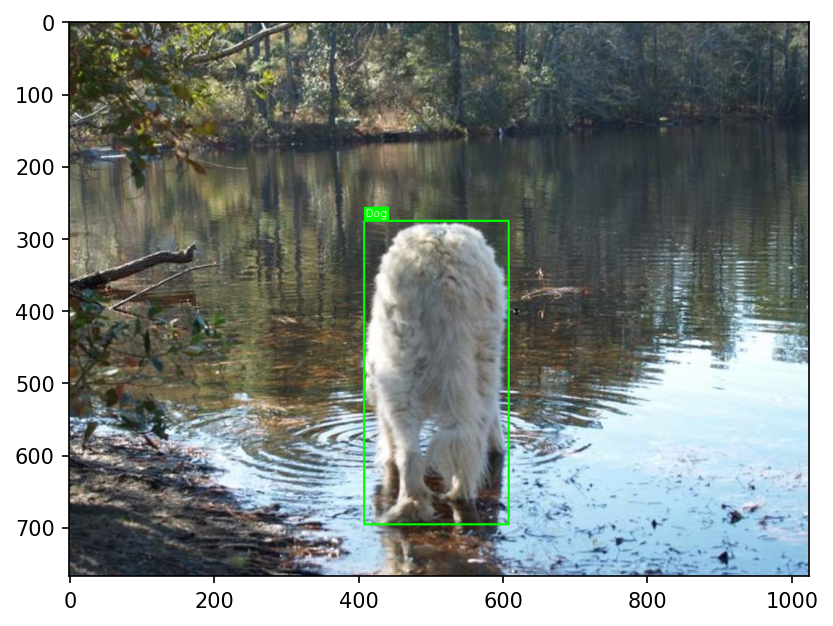

In [33]:
img, target = dataset[5]

print(f'Image dtype = {img.dtype}') # float 0 and 1 range
print(target)
plt.imshow(draw_boxes(img, target["labels"], target["boxes"], classes=new_classes))

#### Augmentations with Albumentations

In [34]:
# Albumentations automatically handles bbox transformations
# keeps bboxes and labels aligned
# pascal_voc => XMin, YMin, XMax, YMax
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.pytorch.transforms.ToTensorV2(p=1.0)
        ],
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )
    else:
        return A.Compose([
            A.pytorch.transforms.ToTensorV2(p=1.0)
        ],
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

In [35]:
# OpenImagesDataset __getitem__ => (image, target)
# if: batch_size = 2 [(image1, target1), (image2, target2)]
# torch default collate will stack but shapes are different for target (can have one or many)
# zip(*batch) => ((image1, image2), (target1, target2))
# no more stacking
def collate_fn(batch):
    return tuple(zip(*batch))

In [36]:
# Recreate base datasets from scratch (important!)
base_train = OpenImagesDataset(
    "OIDv4_ToolKit/OID",
    classes_filter=["Cat", "Dog"],
    transform=get_transform(True)
)
base_test  = OpenImagesDataset(
    "OIDv4_ToolKit/OID",
    classes_filter=["Cat", "Dog"],
    transform=get_transform(False)
)

torch.manual_seed(1)
perm = torch.randperm(len(base_train)).tolist()

test_split = 0.2
tsize = int(len(base_train) * test_split)

train_idx = perm[:-tsize]
test_idx  = perm[-tsize:]

dataset = Subset(base_train, train_idx)
dataset_test = Subset(base_test, test_idx)

data_loader = DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

load annotations
load classes
assign class
remove unused classes
aggregate image info
map ids
load annotations


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


load classes
assign class
remove unused classes
aggregate image info
map ids


In [37]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: cuda


#### New RoI heads

["background", "cat", "dog"]

num_classes = 3

In [38]:
RoI_head = detector.roi_heads.box_predictor
# this model was trained on COCO_V1 80 classes
# 91 classes in cls_score cause 1 is background and others 10 are N/A placeholder classes
RoI_head

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [39]:
num_classes = 3

# change the RoI head of the Faster R-CNN architecture to accomodate a different number of classes
in_features = detector.roi_heads.box_predictor.cls_score.in_features
detector.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)

detector.to(device)
detector.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=3, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
)

In [40]:
optimizer = torch.optim.SGD(
    detector.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# StepLR gradually reduces the learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [41]:
## additional reference files
!mkdir tv_refs
!mkdir -p tv_refs && cd tv_refs && \
curl -O https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py && \
curl -O https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py && \
curl -O https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py && \
curl -O https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py && \
curl -O https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py

mkdir: cannot create directory ‘tv_refs’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063  100  4063    0     0  13494      0 --:--:-- --:--:-- --:--:-- 13543
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8388  100  8388    0     0  28351      0 --:--:-- --:--:-- --:--:-- 28433
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23628  100 23628    0     0  77446      0 --:--:-- --:--:-- --:--:-- 77215
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8409  100  8409    0     0  27291      0 --:--:-- --:--:-- --:--:-- 2730

#### Training for new class from OpenImages v4

In [42]:
import sys
sys.path.append("tv_refs")

In [43]:
# helper functions from torchvision
import pycocotools
import pycocotools.mask as mask_util
from engine import train_one_epoch, evaluate

##### Faster R-CNN Total Loss

`total_loss = loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg`

- **loss_classifier (Cross Entropy)**: predicts the class label for each proposed region  
- **loss_box_reg (BBox Regression)**: refines final bounding box coordinates (RoI head)

- **loss_objectness (BCE)**: predicts object vs background for anchors (RPN)  
- **loss_rpn_box_reg (BBox Regression)**: adjusts anchor boxes into better region proposals (RPN)


In [44]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(detector, optimizer, data_loader, device, epoch, print_freq=20)
    lr_scheduler.step()

/content/tv_refs/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/80]  eta: 0:03:01  lr: 0.000068  loss: 1.6459 (1.6459)  loss_classifier: 0.9862 (0.9862)  loss_box_reg: 0.5307 (0.5307)  loss_objectness: 0.0266 (0.0266)  loss_rpn_box_reg: 0.1024 (0.1024)  time: 2.2720  data: 0.1390  max mem: 4737
Epoch: [0]  [20/80]  eta: 0:00:47  lr: 0.001333  loss: 1.1492 (1.2219)  loss_classifier: 0.5220 (0.6189)  loss_box_reg: 0.4592 (0.5192)  loss_objectness: 0.0298 (0.0358)  loss_rpn_box_reg: 0.0489 (0.0480)  time: 0.7122  data: 0.1345  max mem: 5271
Epoch: [0]  [40/80]  eta: 0:00:29  lr: 0.002597  loss: 0.8670 (1.0646)  loss_classifier: 0.2837 (0.4666)  loss_box_reg: 0.5013 (0.5210)  loss_objectness: 0.0273 (0.0311)  loss_rpn_box_reg: 0.0401 (0.0459)  time: 0.6789  data: 0.1248  max mem: 5271
Epoch: [0]  [60/80]  eta: 0:00:14  lr: 0.003862  loss: 0.6584 (0.9448)  loss_classifier: 0.2313 (0.3946)  loss_box_reg: 0.3600 (0.4754)  loss_objectness: 0.0227 (0.0281)  loss_rpn_box_reg: 0.0464 (0.0467)  time: 0.6492  data: 0.1225  max mem: 5271
Epoch: [

In [45]:
save_path = "fasterrcnn_cat_dog.pth"
torch.save(detector.state_dict(), save_path)

print("Model saved to", save_path)

Model saved to fasterrcnn_cat_dog.pth


In [46]:
detector.load_state_dict(torch.load("fasterrcnn_cat_dog.pth", map_location=device))

<All keys matched successfully>

In [47]:
class CocoIdWrapper(Dataset):
    """
    Ensures each sample has:
      - target["image_id"] as a Python int (0..len-1) unique within this dataset
    This makes torchvision's COCO eval happy without touching engine.py.
    """
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, target = self.ds[idx]

        # make a shallow copy so we don't mutate underlying dataset targets
        target = dict(target)

        # force COCO-style integer ids
        target["image_id"] = int(idx)

        # optional: ensure required types
        # target["boxes"] should be FloatTensor[N,4], labels Int64Tensor[N]
        return img, target

In [48]:
dataset_test_eval = CocoIdWrapper(dataset_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test_eval, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

evaluate(detector, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:25  model_time: 0.3014 (0.3014)  evaluator_time: 0.0112 (0.0112)  time: 1.0325  data: 0.6442  max mem: 5328
Test:  [24/25]  eta: 0:00:00  model_time: 0.2162 (0.2123)  evaluator_time: 0.0036 (0.0038)  time: 0.3115  data: 0.0834  max mem: 5328
Test: Total time: 0:00:08 (0.3435 s / it)
Averaged stats: model_time: 0.2162 (0.2123)  evaluator_time: 0.0036 (0.0038)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU

### NMS Algorithm (Non-Maximum Suppression)

- Compute **area** of a box  
- Compute **intersection area** of two boxes  
- Compute **IoU**:

`IoU = intersection_area / union_area`

Why NMS?
- model may predict **many overlapping boxes**
- often **all with high confidence**
- we **keep the best one** and **remove the rest**
- **high IoU = likely same object**

---

**Example**

Initial state:  
- Box A: score=0.9, IoU(A,B)=0.7, IoU(A,C)=0.2  
- Box B: score=0.85, IoU(B,C)=0.1  
- Box C: score=0.8  

**Step 1: Take Box A (highest score=0.9)**  
- keep = [A]  
- Check B: IoU(A,B)=0.7 > 0.5 → **REMOVE B** (same object)  
- Check C: IoU(A,C)=0.2 < 0.5 → **KEEP C** (different object)  
- remaining = [C]

**Step 2: Take Box C (score=0.8)**  
- keep = [A, C]  
- remaining = []

Result: Keep boxes **A** and **C**


In [49]:
def iou(box1, box2):
    # Find intersection rectangle corners
    x1 = max(box1[0], box2[0])  # leftmost
    y1 = max(box1[1], box2[1])  # topmost
    x2 = min(box1[2], box2[2])  # rightmost
    y2 = min(box1[3], box2[3])  # bottommost

    # Calculate intersection area
    inter_w = max(0, x2 - x1)  # width 0 if not overlap
    inter_h = max(0, y2 - y1)  # height 0 if not overlap
    inter_area = inter_w * inter_h

    # Calculate each box's area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Union = both areas minus intersection (to avoid double-counting)
    union = area1 + area2 - inter_area

    return inter_area / union if union > 0 else 0


def non_maximum_suppression(boxes, scores, iou_thresh=0.5):
    """
    boxes:  Nx4 array [x1, y1, x2, y2]
    scores: N array of confidence scores
    returns: indices of kept boxes
    """
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Sort by confidence (highest first)
    order = scores.argsort()[::-1]

    keep = []

    while len(order) > 0:
        i = order[0]
        keep.append(i)
        if len(order) == 1:  # Last box, nothing to compare
            break

        # Vectorized: check all remaining boxes at once
        ious = np.array([iou(boxes[i], boxes[j]) for j in order[1:]])
        order = order[1:][ious <= iou_thresh]

    return keep

### mAP (Mean Average Precision)

- Calculate AP (Average Precision) for each class
- Average them together

---

**Example**

- AP_cat = 0.85
- AP_dog = 0.78
- mAP = (0.85 + 0.78) / 2 = 0.815

In [68]:
def collect_detections(dataset, detector, device="cuda"):
    detector.eval()
    detector.to(device)

    # Ground truths: {class_id: {img_idx: [box1, box2]}}
    gt = defaultdict(lambda: defaultdict(list))

    # Predictions: {class_id: [(img_idx, score, box)]}
    preds = defaultdict(list)

    for idx in tqdm(range(len(dataset))):
        img, target = dataset[idx]
        img = img.to(device)

        with torch.no_grad():
            result = detector([img])[0]

        # Collect ground truths
        for box, label in zip(target["boxes"], target["labels"]):
            label_item = label.item() if torch.is_tensor(label) else int(label)
            if label_item != 0:  # Skip background
                gt[label_item][idx].append(box.cpu().numpy() if torch.is_tensor(box) else box)

        # Collect predictions
        boxes = result["boxes"].cpu().numpy()
        scores = result["scores"].cpu().numpy()
        labels = result["labels"].cpu().numpy()

        # Apply NMS
        keep = non_maximum_suppression(boxes, scores, iou_thresh=0.5)

        for i in keep:
            label_item = int(labels[i])
            if label_item != 0:  # Skip background
                preds[label_item].append((idx, float(scores[i]), boxes[i]))

    return gt, preds

In [51]:
# average percision per class

# Example
# Ground truth: 5 cats total
# Image 0: 2 cats
# Image 1: 1 cat
# Image 2: 2 cats

# Predictions (sorted by confidence)
# 1. img=0, score=0.9,  box → matches gt cat  (TRUE POSITIVE)
# 2. img=0, score=0.85, box → matches gt cat  (TRUE POSITIVE)
# 3. img=1, score=0.8,  box → matches gt cat  (TRUE POSITIVE)
# 4. img=2, score=0.7,  box → no match        (FALSE POSITIVE)
# 5. img=2, score=0.65, box → matches gt cat  (TRUE POSITIVE)

def average_pecision(gt, preds, class_id, iou_thresh=0.5, use_11_point=False):
    predictions = preds[class_id]

    # sort by confidence
    predictions.sort(key=lambda x: x[1], reverse=True)

    # count total gt objects not samples
    total_gt = sum(len(v) for v in gt[class_id].values())

    tp = np.zeros(len(predictions))  # [0, 0, 0, 0, 0]
    fp = np.zeros(len(predictions))  # [0, 0, 0, 0, 0]

    # to prevent double counting
    used = {img_id: np.zeros(len(boxes)) for img_id, boxes in gt[class_id].items()}

    for i, (img_id, score, box) in enumerate(predictions):
            # is there ground truth in this image?
            if img_id not in gt[class_id]:
                fp[i] = 1  # False positive (predicted cat where there isn't one)
                continue

            # calculate IoU with all GT boxes
            ious = [iou(box, gt_box) for gt_box in gt[class_id][img_id]]
            max_iou = max(ious)
            max_idx = np.argmax(ious)  # best match

            if max_iou >= 0.5 and used[img_id][max_idx] == 0:
                tp[i] = 1
                used[img_id][max_idx] = 1
            else:
                fp[i] = 1  # FALSE POSITIVE (IoU too low or GT already matched)

    # cumulative sum
    tp = np.cumsum(tp)  # [1, 2, 3, 3, 4]
    fp = np.cumsum(fp)  # [0, 0, 0, 1, 1]

    # sensitivity = tp / (tp + fn)
    recall = tp / total_gt

    # precision = tp / (tp + fp)
    precision = tp / (tp + fp)

    # area under the curve - AP
    # VOC-11 point interpolation
    if use_11_point:
        ap = 0.0
        for r in np.linspace(0, 1, 11):
            p = precision[recall >= r]
            ap += p.max() if p.size > 0 else 0.0
        ap /= 11.0
        return ap

    # all-points interpolation
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    for j in range(len(mpre) - 2, -1, -1):
        mpre[j] = max(mpre[j], mpre[j + 1])

    ap = np.sum((mrec[1:] - mrec[:-1]) * mpre[1:])
    return ap

In [52]:
def mean_average_precision(gt, preds, class_ids):
    aps = {}
    for c in class_ids:
        aps[c] = average_pecision(gt, preds, c)
    mAP = sum(aps.values()) / len(aps)
    return mAP, aps

In [53]:
gt, preds = collect_detections(dataset, detector, device)
mAP, APs = mean_average_precision(gt, preds, [1, 2])

print("APs:", APs)
print("mAP:", mAP)

GT => defaultdict(<function collect_detections.<locals>.<lambda> at 0x7c4731afede0>, {})
preds = defaultdict(<class 'list'>, {})


100%|██████████| 798/798 [00:31<00:00, 25.58it/s]

APs: {1: np.float64(nan), 2: np.float64(nan)}
mAP: nan



/tmp/ipython-input-1738365363.py:53: RuntimeWarning: invalid value encountered in divide
  recall = tp / total_gt


### Tuning with 1K Castle training images from OIDv4

In [54]:
! cd ./OIDv4_ToolKit/OID/Dataset/train/Castle/ && ls -1 | wc -l
! cd ./OIDv4_ToolKit/OID/Dataset/test/Castle/ && ls -1 | wc -l

1001
72


In [55]:
dataset = OpenImagesDataset("OIDv4_ToolKit/OID", classes_filter=["Castle"])

load annotations
load classes
assign class
remove unused classes
aggregate image info
map ids


In [56]:
new_classes = dataset.class_names
print(new_classes)
print(dataset)
print(dataset.class_dict)

['BACKGROUND', 'Castle']
Dataset Summary:Number of Images: 1000
Minimum Number of Images for a Class: -1
Label Distribution:
	Castle: 1171
{'BACKGROUND': 0, 'Castle': 1}


##### Stronger Augmentations

In [57]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.2,
                rotate_limit=15,
                border_mode=0,
                p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.25,
                contrast_limit=0.25,
                p=0.5
            ),
            A.HueSaturationValue(
                hue_shift_limit=15,
                sat_shift_limit=20,
                val_shift_limit=20,
                p=0.4
            ),
            A.OneOf([
                A.GaussianBlur(blur_limit=3, p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
            ], p=0.25),                 # 0.2 → 0.25
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),
            A.pytorch.transforms.ToTensorV2(p=1.0)
        ],
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )
    else:
        return A.Compose([
            A.pytorch.transforms.ToTensorV2(p=1.0)
        ],
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

In [58]:
base_train = OpenImagesDataset(
    "OIDv4_ToolKit/OID",
    classes_filter=["Castle"],
    transform=get_transform(True)
)
base_test  = OpenImagesDataset(
    "OIDv4_ToolKit/OID",
    classes_filter=["Castle"],
    transform=get_transform(False)
)

torch.manual_seed(1)
perm = torch.randperm(len(base_train)).tolist()

test_split = 0.2
tsize = int(len(base_train) * test_split)

train_idx = perm[:-tsize]
test_idx  = perm[-tsize:]

dataset = Subset(base_train, train_idx)
dataset_test = Subset(base_test, test_idx)

data_loader = DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

load annotations


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1665480467.py:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),


load classes
assign class
remove unused classes
aggregate image info
map ids
load annotations


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


load classes
assign class
remove unused classes
aggregate image info
map ids


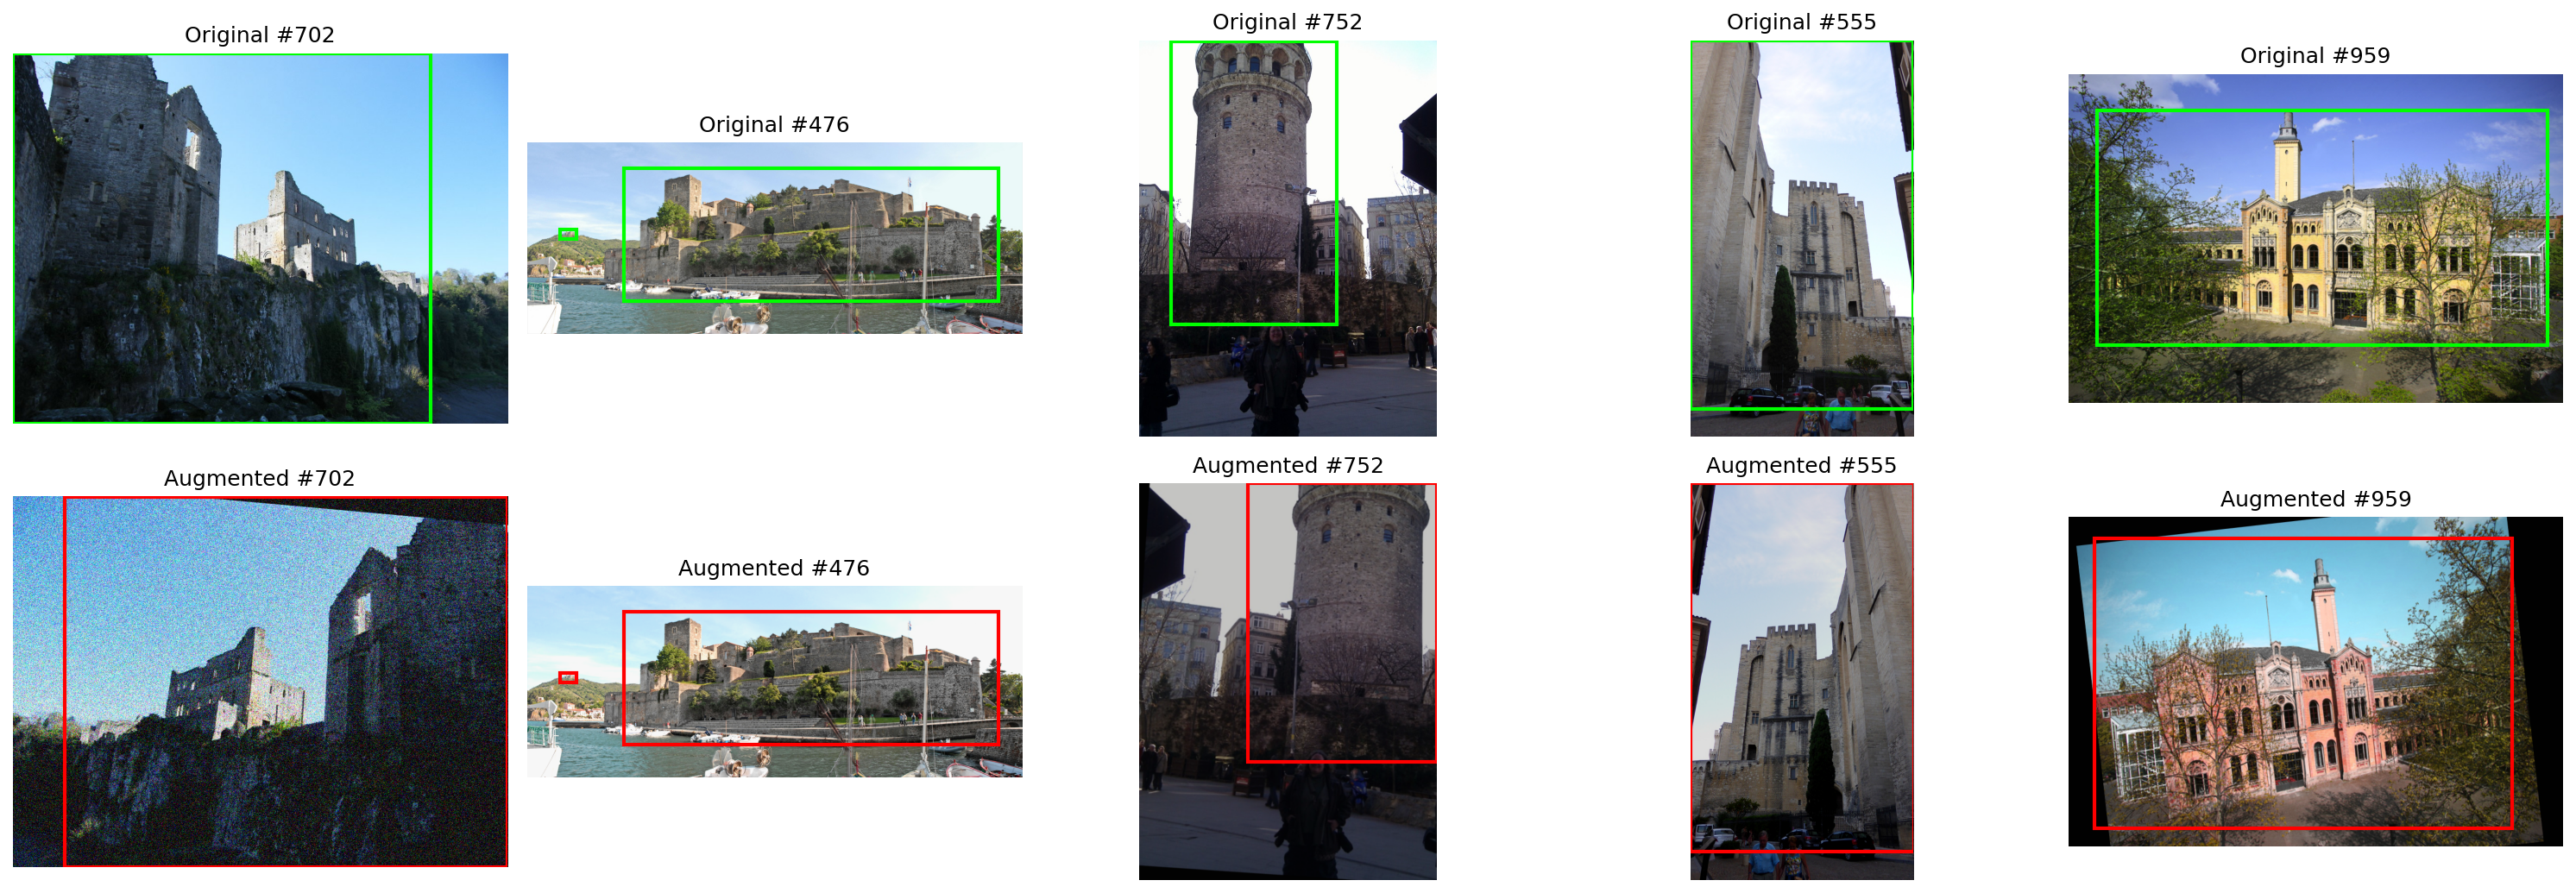

In [59]:
def show_5_orig_vs_aug(base_test, base_train, n=5):
    idxs = random.sample(range(len(base_test)), n)

    fig, axes = plt.subplots(2, n, figsize=(4*n, 7))

    for i, idx in enumerate(idxs):
        orig_img, orig_t = base_test[idx]  # No augmentation
        aug_img, aug_t = base_train[idx]   # Random augmentation
        for row, (img, t, title, color) in enumerate([
            (orig_img, orig_t, "Original", "lime"),
            (aug_img,  aug_t,  "Augmented", "red"),
        ]):
            ax = axes[row, i]
            img_np = img.cpu().numpy().transpose(1, 2, 0)
            ax.imshow(np.clip(img_np, 0, 1))

            for (x1, y1, x2, y2) in t["boxes"].cpu().numpy():
                ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                               linewidth=2, edgecolor=color, facecolor="none"))

            ax.set_title(f"{title} #{idx}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


show_5_orig_vs_aug(base_test, base_train, 5)

In [60]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: cuda


In [61]:
num_classes = 2

in_features = detector.roi_heads.box_predictor.cls_score.in_features
detector.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)

detector.to(device)
detector.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

In [62]:
optimizer = torch.optim.SGD(
    detector.parameters(),
    lr=0.002,
    momentum=0.9,
    weight_decay=0.0005
)

# StepLR gradually reduces the learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.3
)

In [63]:
num_epochs = 15

for epoch in range(num_epochs):
    train_one_epoch(detector, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

/content/tv_refs/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/80]  eta: 0:01:44  lr: 0.000027  loss: 2.9487 (2.9487)  loss_classifier: 0.5188 (0.5188)  loss_box_reg: 0.0617 (0.0617)  loss_objectness: 2.1915 (2.1915)  loss_rpn_box_reg: 0.1767 (0.1767)  time: 1.3099  data: 0.4507  max mem: 5328
Epoch: [0]  [10/80]  eta: 0:00:59  lr: 0.000280  loss: 2.5212 (2.5732)  loss_classifier: 0.4646 (0.4721)  loss_box_reg: 0.2419 (0.2173)  loss_objectness: 1.6864 (1.7221)  loss_rpn_box_reg: 0.1280 (0.1617)  time: 0.8518  data: 0.2931  max mem: 5328
Epoch: [0]  [20/80]  eta: 0:00:53  lr: 0.000533  loss: 1.1939 (1.7043)  loss_classifier: 0.3527 (0.3635)  loss_box_reg: 0.2633 (0.2524)  loss_objectness: 0.3441 (0.9535)  loss_rpn_box_reg: 0.1137 (0.1349)  time: 0.8677  data: 0.2728  max mem: 5421
Epoch: [0]  [30/80]  eta: 0:00:45  lr: 0.000786  loss: 0.6233 (1.3477)  loss_classifier: 0.1775 (0.3014)  loss_box_reg: 0.2652 (0.2536)  loss_objectness: 0.0649 (0.6670)  loss_rpn_box_reg: 0.1050 (0.1257)  time: 0.9426  data: 0.2667  max mem: 5421
Epoch: [

In [64]:
save_path = "fasterrcnn_castle.pth"
torch.save(detector.state_dict(), save_path)

print("Model saved to", save_path)

Model saved to fasterrcnn_castle.pth


In [65]:
detector.load_state_dict(torch.load("fasterrcnn_castle.pth", map_location=device))

<All keys matched successfully>

In [69]:
gt, preds = collect_detections(dataset, detector, device)
mAP, APs = mean_average_precision(gt, preds, [1, 2])

print("APs:", APs)
print("mAP:", mAP)

100%|██████████| 800/800 [00:46<00:00, 17.19it/s]

APs: {1: np.float64(0.865891569396647), 2: np.float64(0.0)}
mAP: 0.4329457846983235


In [67]:
dataset_test_eval = CocoIdWrapper(dataset_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test_eval, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

evaluate(detector, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:10  model_time: 0.3050 (0.3050)  evaluator_time: 0.0122 (0.0122)  time: 0.4035  data: 0.0706  max mem: 5512
Test:  [24/25]  eta: 0:00:00  model_time: 0.2357 (0.2290)  evaluator_time: 0.0037 (0.0045)  time: 0.3527  data: 0.0995  max mem: 5512
Test: Total time: 0:00:08 (0.3462 s / it)
Averaged stats: model_time: 0.2357 (0.2290)  evaluator_time: 0.0037 (0.0045)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=